# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Data Curation Part 2

Today we'll extend our dataset to a greater coverage, and craft it into an excellent dataset for training.  
Data curation can seem less exciting than other things we work on, but it's a crucial part of the LLM engineers' responsibility and an important craft to hone, so that you can build your own commercial solutions with high quality datasets.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Important Note - read me first please

We are about to craft a massive dataset of 400,000 items covering multiple types of product. In Week 7 we will be using this data to train our own model. It's a pretty big dataset, and depending on the GPU you select, training could take 20+ hours. It will be really good fun, but it could cost a few dollars in compute units.

As an alternative, if you want to keep things quick & low cost, you can work with a smaller dataset focused only on Home Appliances. You'll be able to cover the same learning points; the results will be good -- not quite as good as the full dataset, but still pretty amazing! If you'd prefer to do this, I've set up an alternative jupyter notebook in this folder called `lite.ipynb` that you should use in place of this one.

Also, if you'd prefer, you can shortcut running all this data curation by downloading the pickle files that we save in the last cell. The pickle files are available here: https://drive.google.com/drive/folders/1f_IZGybvs9o0J5sb3xmtTEQB3BXllzrW

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
# os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# More imports after HF login

from loaders import ItemLoader
from items import Item

In [5]:
%matplotlib inline

## The ItemLoader code

Look in loaders.py - there's some useful code to make life easier for us

In [6]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [00:13<00:00,  7.23it/s]


Completed Appliances with 28,625 datapoints in 0.3 mins


In [7]:
# Look for a familiar item..
print(items[1].PREFIX)

Price is $


## Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [110]:
dataset_names = [
    "CDs_and_Vinyl",
    "Appliances",
    "Baby_Products",
    "Handmade_Products",
    "Musical_Instruments",
    "Software",
    "Video_Games",
    "Unknown"
]

In [111]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!    
# By the way, I put the biggest datasets first.. it gets faster.

Loading dataset CDs_and_Vinyl


100%|██████████| 702/702 [00:58<00:00, 12.06it/s]


Completed CDs_and_Vinyl with 184,932 datapoints in 1.2 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:14<00:00,  6.53it/s]


Completed Appliances with 28,625 datapoints in 0.3 mins
Loading dataset Baby_Products


100%|██████████| 218/218 [00:24<00:00,  8.99it/s]


Completed Baby_Products with 54,653 datapoints in 0.5 mins
Loading dataset Handmade_Products


100%|██████████| 165/165 [00:26<00:00,  6.27it/s]


Completed Handmade_Products with 64,189 datapoints in 0.5 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [00:25<00:00,  8.35it/s]


Completed Musical_Instruments with 66,829 datapoints in 0.5 mins
Loading dataset Software


100%|██████████| 90/90 [00:11<00:00,  7.98it/s]


Completed Software with 14,635 datapoints in 0.3 mins
Loading dataset Video_Games


100%|██████████| 138/138 [00:20<00:00,  6.85it/s]


Completed Video_Games with 49,843 datapoints in 0.5 mins
Loading dataset Unknown


100%|██████████| 391/391 [00:15<00:00, 24.52it/s]


Completed Unknown with 9,878 datapoints in 0.4 mins


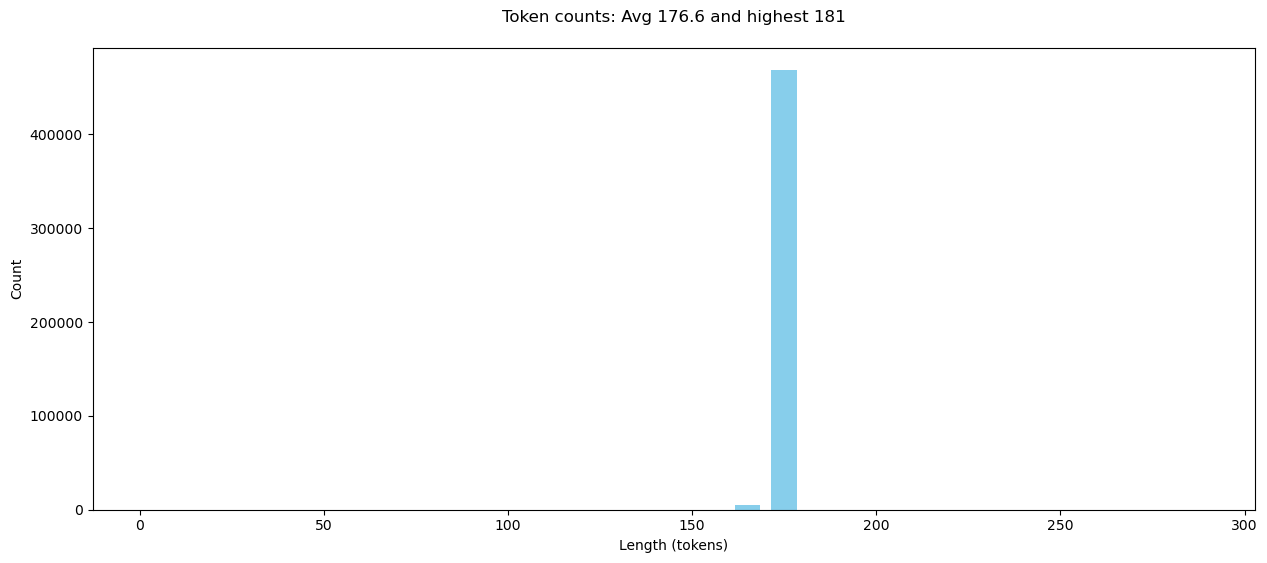

In [112]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

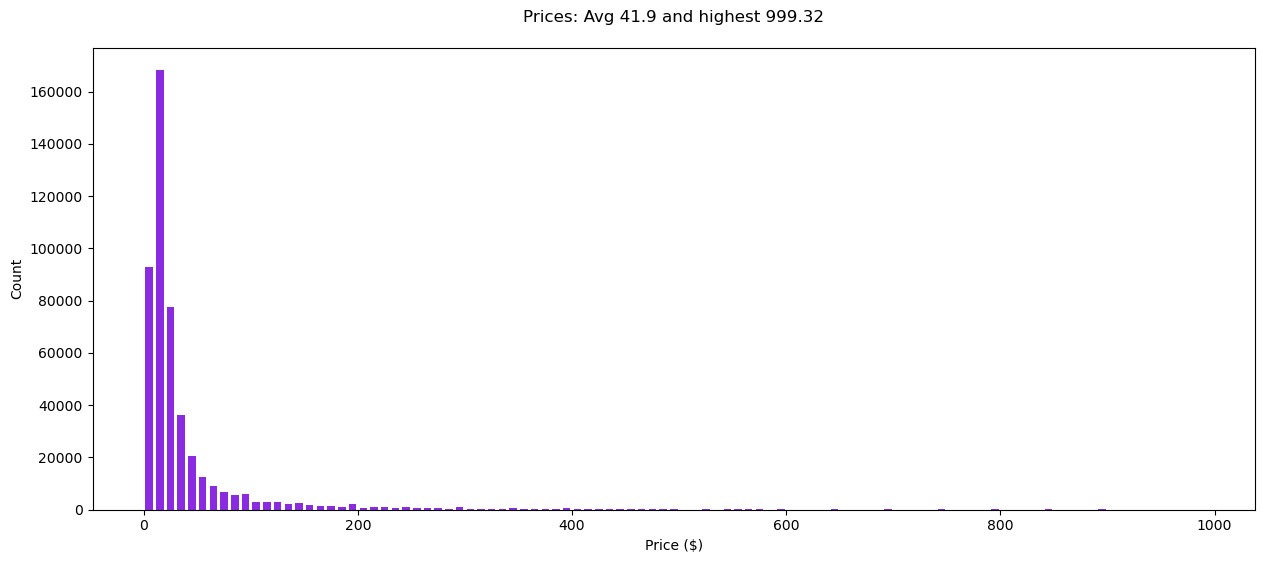

In [113]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

In [114]:
print(items.__len__())

473584


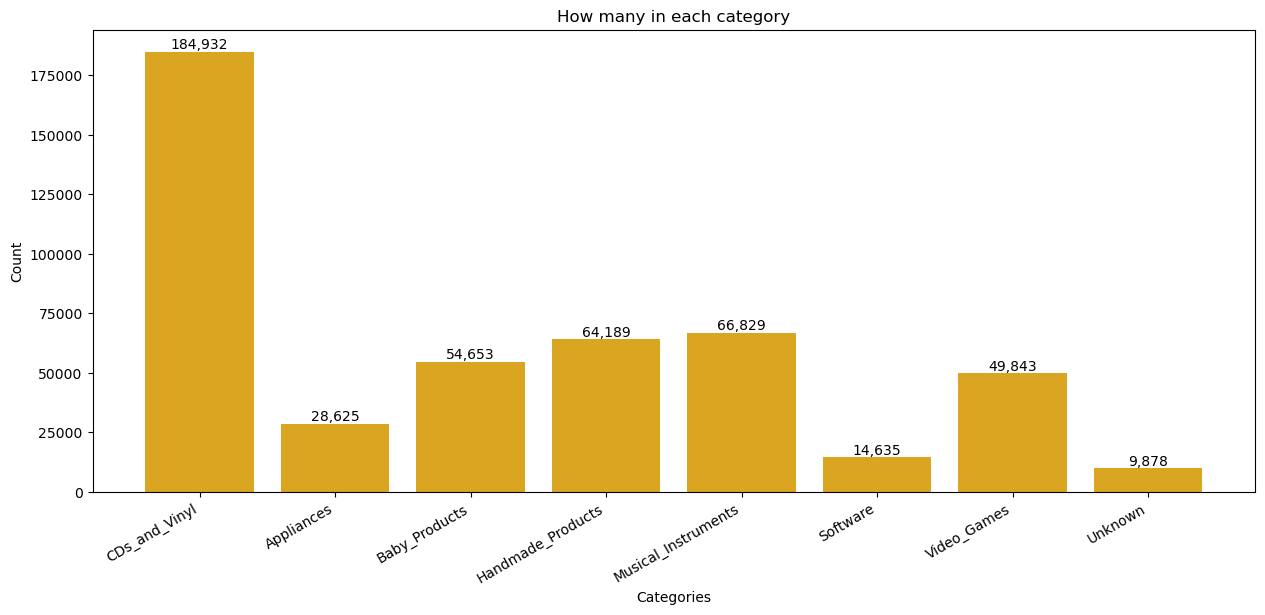

In [120]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [121]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [122]:
categories_sorted_by_price = dict(category_counts.most_common())

print(categories_sorted_by_price)
print(slots.__len__())
    



{'CDs_and_Vinyl': 184932, 'Musical_Instruments': 66829, 'Handmade_Products': 64189, 'Baby_Products': 54653, 'Video_Games': 49843, 'Appliances': 28625, 'Software': 14635, 'Unknown': 9878}
939


In [123]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility


np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=200:
        sample.extend(slot)
    elif len(slot) <= 800:
        sample.extend(slot)
    else:
        weights = np.array([ categories_sorted_by_price[item.category] for item in slot])
        # weights = np.array( [5 if item.category == 'CDs_and_Vinyl' else 1 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=800, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 105,146 items in the sample


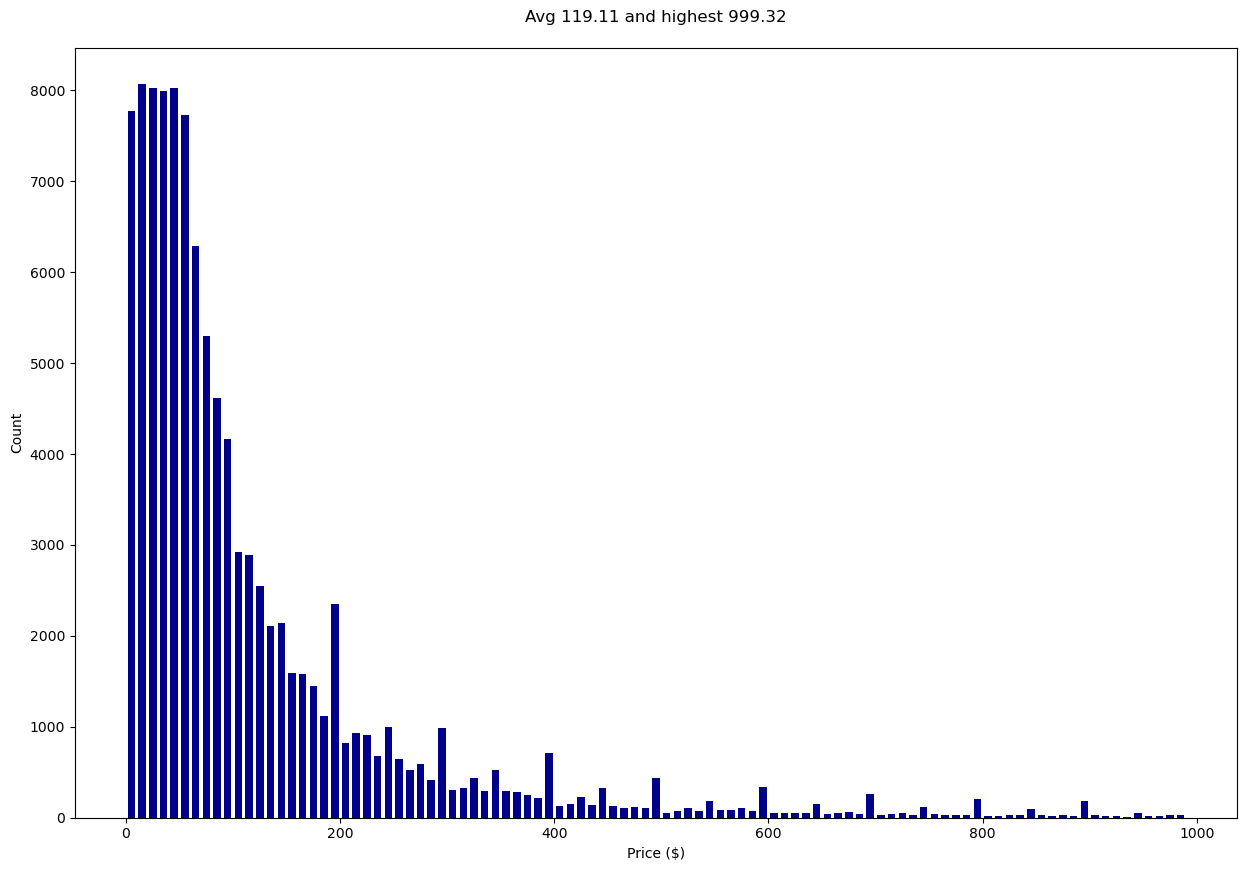

In [124]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

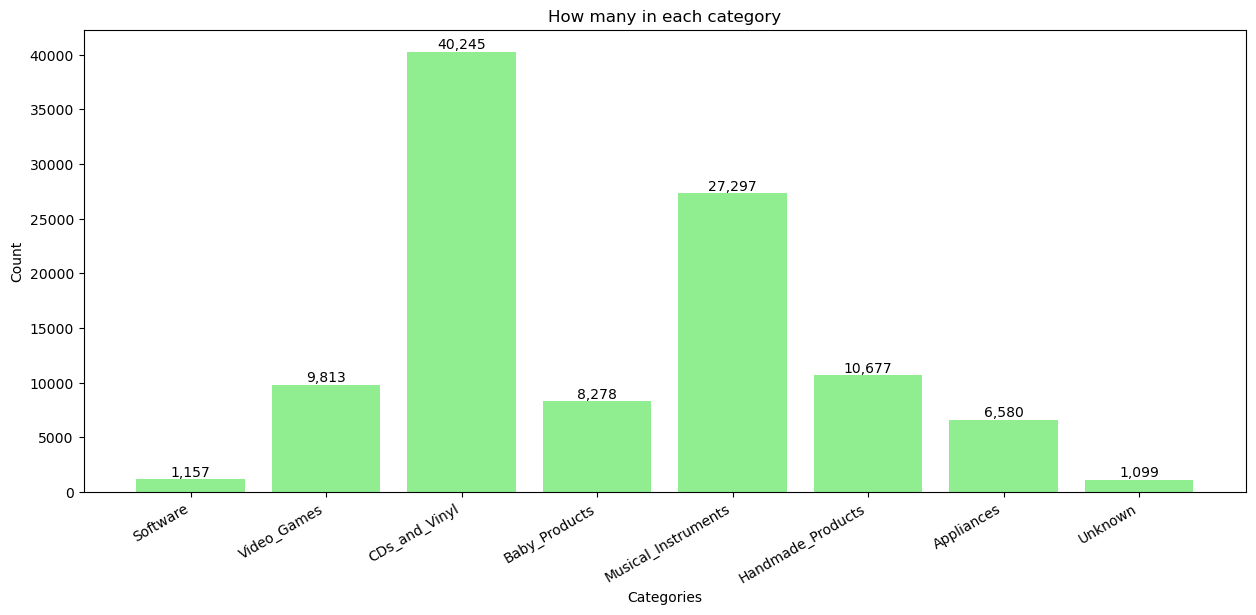

In [125]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

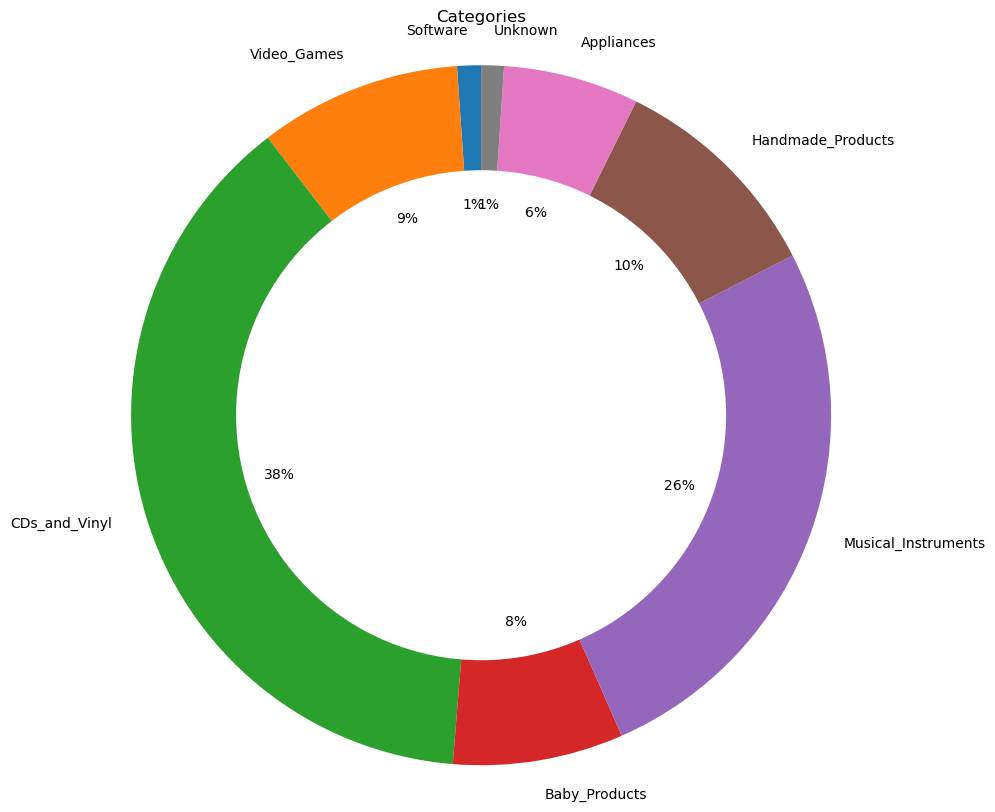

In [126]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

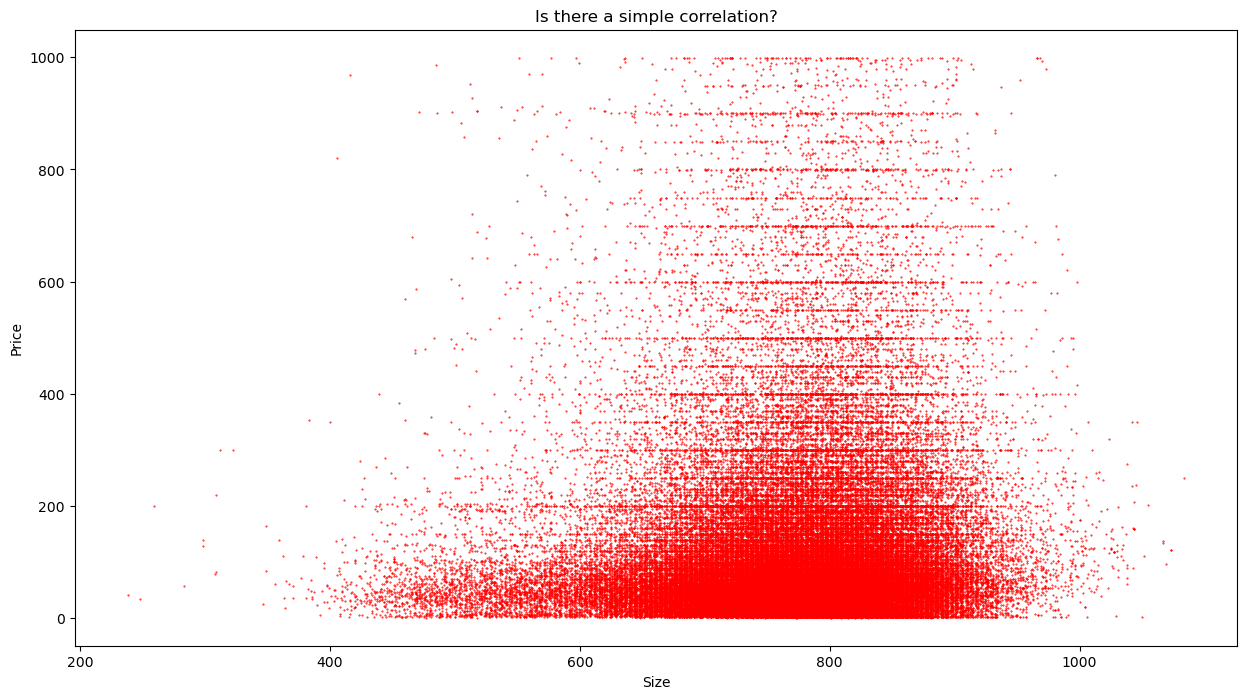

In [127]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [128]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [131]:
report(sample[99221])

How much does this cost to the nearest dollar?

Yamaha MG12XU 4-Bus Mixer with Effects
Yamaha MG12XU Channel Analog 4-Bus Mixer with Effects For more than a century, Yamaha has been building a legacy of superior craftsmanship and innovation exemplified in all of our products, from an unrivaled catalog of world-class musical instruments to touring-grade professional audio. Now in its third incarnation, the MG Series embodies this pursuit of design excellence, and incorporates some of the same technologies developed for use in high-end professional consoles, including studio-quality preamps, powerful digital processing, and a rugged, reliable construction. With an intuitive, easy-to-use interface, the MG Series boasts an extensive lineup of compact mixing consoles with models ranging from six to twenty channels, suitable for a diverse range of users and applications. For

Price is $398.00
[8522, 13, 1789, 271, 7117, 374, 400, 19838, 13, 410]
[' applications', '.', ' For', '\n\n', 'Price'

## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [137]:
random.seed(42)
random.shuffle(sample)
train = sample[:100_000]
test = sample[100_000:105_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 100,000 items and test set of 5,000 items


In [138]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Peter Jackson's King Kong
From the Manufacturer Acclaimed game creator Michel Ancel and the Montpellier studio collaborate with triple Academy Award winning filmmaker Peter Jackson and visual-effects company Weta Ltd. to develop Peter Jacksons King Kong, a video game that will capture the imagination, vision, and emotion of the epic film. Delve deeper into the film experience through alternative viewpoints designed to immerse the player into the action and truly feel the tension of the adventure. Features Unprecedented alternating gameplay battle for survival on Skull Island in first-person as Jack Driscoll and experience the staggering power of King Kong in third-person taking on massive beasts. Unprecedented alternating gameplay battle for survival on Skull Island in first-person as Jack Driscoll and experience the staggering power of King Kong in third-person taking on massive

Price is $70.00


In [139]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

The ONE Smart Keyboard COLOR 61 Lighted Keys Piano Keyboard, Electric Piano for Beginners with 256 Tones, 64 Polyphony, Built-in LED Lights & Apps, Supports USB MIDI/Headphones (Purple)
Your Keyboard Tutor Follow the built-in red LED lights and play along with more than 4000 sheet music, 100 instructional videos and games in our apps. The ONE Smart Keyboard is your personal music teacher that makes learning fun and fast. Variety of Sounds & Styles Choose from 256 timbres, 64 polyphony, 61 full-sized keys and 7 color options to customize your playing experience. 2 (3w) speakers, 1 headphone connector volume control, recording, and MIDI functionality are all accessible. Connect your keyboard to our app via iOS/ Android

Price is $


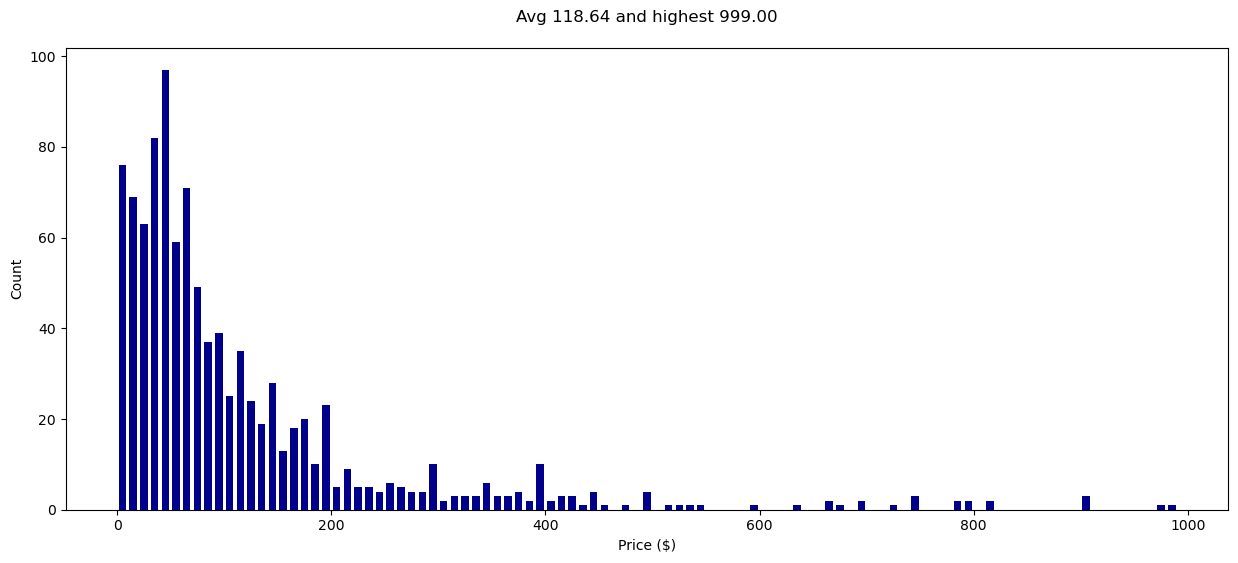

In [142]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:1000]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [143]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [144]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [145]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username

HF_USER = "AnnBuiii"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/AnnBuiii/pricer-data/commit/67bca25e7b6d0a5cf1d63f9546d038011b112b48', commit_message='Upload dataset', commit_description='', oid='67bca25e7b6d0a5cf1d63f9546d038011b112b48', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/AnnBuiii/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='AnnBuiii/pricer-data'), pr_revision=None, pr_num=None)

In [146]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

## Todos for you:

- Investigate the dataset more!
- Confirm that the tokenizer tokenizes all 3 digit prices into 1 token